# (Step 3 for PTE) PTE analysis for the cyclone core 

Original script written by Georgios Papavasileiou 

Modified by Ting-Chen Chen (ting-chen.chen@kit.edu) 

Adjusted to multiple timestep input, simplified and strongly reduced functionality by Christoph Braun in January, 2024. The modifications introduced have been checked using the script Check_mod_of_PTEstep3.ipynb. There are very minor quantitative differences in the final results. I classify these as acceptable.

In [1]:
exp='channel_2km_0004'
dt = 6
#data_res  = '1x1latlon'
data_res  = '0p05x0p05latlon'
if   dt == 1:
     data_dt = '1hrly'
elif dt == 6:
     data_dt = '6hrly'
        
p2level=50


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# required
import xarray as xr

In [3]:
#####################################################
# Read in track data from file
#####################################################
#Cyclone Track
path_track = '/work/bb1152/Module_A/A6_CyclEx/pp_data/cyclone_tracks/'

#df_track = pd.read_csv(path_track+'Track_for_'+exp+'_'+str(dt)+'hrly_1x1latlon.csv')
df_track = pd.read_csv(path_track+'Track_for_'+exp+'_'+str(dt)+'hrly_0p05x0p05latlon.csv')
    
df_track

Unnamed: 0  time         pmin    lon    lat
0            0  0.00  1000.992554  63.45  21.85
1            1  0.25   997.893372  24.90  21.70
2            2  0.50   998.454346  21.00  42.75
3            3  0.75   997.009277  32.05  28.00
4            4  1.00   999.555908  27.65  42.70
5            5  1.25   997.663269  27.25  43.50
6            6  1.50   998.044556  31.80  44.90
7            7  1.75   997.646118  40.00  42.25
8            8  2.00   996.952942  45.55  44.45
9            9  2.25   995.527344  50.15  43.70
10          10  2.50   992.900330  52.20  44.45
11          11  2.75   988.245789  57.35  44.85
12          12  3.00   985.206177  59.70  45.40
13          13  3.25   980.555298  14.55  45.65
14          14  3.50   974.838745  16.80  46.55
15          15  3.75   969.989685  18.90  46.50
16          16  4.00   967.316772  23.65  47.70
17          17  4.25   966.005371  29.80  48.15
18          18  4.50   962.631165  36.00  48.70
19          19  4.75   960.460876  38.80  49.25
20          20  5.00   959.456299  42.30  49.90
21          21  5.25   958.772339  47.30  50.25
22          22  5.50   953.865234  54.35  50.60
23          23  5.75   949.932861  60.85  50.05
24          24  6.00   942.506226  13.05  51.05
25          25  6.25   938.006470  14.15  51.65
26          26  6.50   941.526733  14.55  50.20
27          27  6.75   943.383057  23.35  53.05
28          28  7.00   944.365479  28.90  53.40
29          29  7.25   944.550171  34.20  52.85
30          30  7.50   944.470642  35.00  53.40
31          31  7.75   944.843750  39.45  53.30
32          32  8.00   947.720947  46.60  52.05
33          33  8.25   951.256653  46.00  53.45
34          34  8.50   954.463806  55.20  50.85
35          35  8.75   960.283997  54.00  51.25
36          36  9.00   962.847351  23.70  46.70

In [5]:
#ipath = '/work/bb1152/Module_A/A6_CyclEx/b380782_Christoph/temp_PTE_out/PTE/maps/'
ipath = '/work/bb1152/Module_A/A6_CyclEx/pp_data/PTE_maps/'

#ifile = "PTE_map_for_"+exp+"_"+data_dt+"_"+data_res+"_upper"+str(int(p2level))+"hPa.nc"
# files for 0.05° analysis are located in a subdirectory
ifile = "PTE_map_for_"+exp+"_"+data_dt+"_"+data_res+"_upper"+str(int(p2level))+"hPa/PTE_map_for_"+exp+"_"+data_dt+"_"+data_res+"_upper"+str(int(p2level))+"hPa_day*.nc"

# read the data
data_file= ipath+ifile

In [6]:
ds = xr.open_mfdataset(data_file)

Make some definitions

In [11]:
# list all vars
ds_vars = list(ds.keys())

# get lon of central point of lon-coordinate
lon_cen = ds.lon[int(ds.lon.size/2)]

# get dlon assuming equidistand spacing
dlon = ds.lon[1].values-ds.lon[0].values

# set boxsize
boxsize = 6

In [18]:
# calculation of boxmean weighted by lat
def get_boxmean(ds: xr.Dataset) -> xr.Dataset:
    
    weights = np.cos(np.deg2rad(ds.lat))
    ds_mean = ds.weighted(weights=weights).mean(dim=['lat','lon'])
    
    return ds_mean

In [19]:
# initialize empty slots for all vars
for var in ds_vars:
    df_track[var] = pd.Series()

In [20]:
# loop over timesteps
for ftime in ds.time:
    # select timestep
    ds_temp = ds.sel(time=ftime)
    
    # get index of panda dataframe fitting current timestep
    itime_df = float(df_track.index[df_track['time']==float(ftime)].values)
    
    # get lon and lat of pmin from cyclone track data
    lon_pmin = df_track['lon'][itime_df]
    lat_pmin = df_track['lat'][itime_df]
    
    # center map on cyclone center
    lon_to_roll = int((lon_cen - lon_pmin)/dlon)
    
    # set lon at cyclone center to 0
    ds_temp['lon'] = ds_temp['lon']-lon_cen
    
    # select box around cyclone center and calculate weighted boxmean
    ds_box = ds_temp.roll(shifts={'lon':lon_to_roll}).sel(lat=slice(lat_pmin-boxsize/2,lat_pmin+boxsize/2),lon=slice(-boxsize/2,boxsize/2))
    ds_boxmean = get_boxmean(ds_box)
    
    # Plotting to check centering and box
    #ds_box.mslp.plot.pcolormesh()
    #plt.show()
    
    # Write results in hPa/6hrs into dataframe 
    for var in ds_vars:
        df_track[var][itime_df] = float(ds_boxmean[var].values)/100

In [21]:
df_track

Unnamed: 0  time         pmin    lon    lat        mslp   dpsfc_dt   
0            0  0.00  1000.992554  63.45  21.85         NaN        NaN  \
1            1  0.25   997.893372  24.90  21.70         NaN        NaN   
2            2  0.50   998.454346  21.00  42.75         NaN        NaN   
3            3  0.75   997.009277  32.05  28.00         NaN        NaN   
4            4  1.00   999.555908  27.65  42.70         NaN        NaN   
5            5  1.25   997.663269  27.25  43.50         NaN        NaN   
6            6  1.50   998.044556  31.80  44.90         NaN        NaN   
7            7  1.75   997.646118  40.00  42.25  997.894609  -1.439854   
8            8  2.00   996.952942  45.55  44.45  997.684531  -1.111958   
9            9  2.25   995.527344  50.15  43.70  996.184141  -2.578686   
10          10  2.50   992.900330  52.20  44.45  993.917891  -2.956397   
11          11  2.75   988.245789  57.35  44.85  990.409219  -5.800087   
12          12  3.00   985.206177  59.70  45.40  988.273047  -3.635371   
13          13  3.25   980.555298  14.55  45.65  985.688516  -6.590565   
14          14  3.50   974.838745  16.80  46.55  982.148984  -6.076429   
15          15  3.75   969.989685  18.90  46.50  978.316641  -3.669097   
16          16  4.00   967.316772  23.65  47.70  974.079922  -4.638983   
17          17  4.25   966.005371  29.80  48.15  971.166875   -5.70832   
18          18  4.50   962.631165  36.00  48.70  968.000156  -7.191995   
19          19  4.75   960.460876  38.80  49.25  966.171875  -4.696962   
20          20  5.00   959.456299  42.30  49.90  965.544141  -3.059304   
21          21  5.25   958.772339  47.30  50.25  963.336016  -4.394081   
22          22  5.50   953.865234  54.35  50.60  959.865156  -8.597279   
23          23  5.75   949.932861  60.85  50.05  954.789219 -11.560167   
24          24  6.00   942.506226  13.05  51.05  950.683047  -9.615369   
25          25  6.25   938.006470  14.15  51.65  948.713906  -3.863569   
26          26  6.50   941.526733  14.55  50.20  953.324922   6.527158   
27          27  6.75   943.383057  23.35  53.05  949.918906  -4.134673   
28          28  7.00   944.365479  28.90  53.40  950.232813  -4.783029   
29          29  7.25   944.550171  34.20  52.85  949.471641  -7.052899   
30          30  7.50   944.470642  35.00  53.40  949.993594   -1.37561   
31          31  7.75   944.843750  39.45  53.30  950.553437  -1.844292   
32          32  8.00   947.720947  46.60  52.05  954.337344  -1.915869   
33          33  8.25   951.256653  46.00  53.45  957.996484   1.707187   
34          34  8.50   954.463806  55.20  50.85  961.748359   0.423549   
35          35  8.75   960.283997  54.00  51.25  966.938437   4.830325   
36          36  9.00   962.847351  23.70  46.70  968.162344  -2.145798   

      dfi_dt        EP       ITT    Eq1res       TADV        VMT   DIABres  
0        NaN       NaN       NaN       NaN        NaN        NaN       NaN  
1        NaN       NaN       NaN       NaN        NaN        NaN       NaN  
2        NaN       NaN       NaN       NaN        NaN        NaN       NaN  
3        NaN       NaN       NaN       NaN        NaN        NaN       NaN  
4        NaN       NaN       NaN       NaN        NaN        NaN       NaN  
5        NaN       NaN       NaN       NaN        NaN        NaN       NaN  
6        NaN       NaN       NaN       NaN        NaN        NaN       NaN  
7  -1.298455 -0.001039 -0.132859 -0.007501  -3.161065  -0.070707  3.098913  
8  -3.201873 -0.017426  2.351068 -0.243726  -4.989049   1.071043  6.269072  
9  -1.398549 -0.057437 -1.202944  0.080246  -4.445321   3.817695 -0.575318  
10 -0.172485 -0.129516 -2.791819  0.137424  -4.784492   5.993924 -4.001249  
11 -3.933174 -0.189275 -1.771041  0.093405  -7.069056   6.309308 -1.011294  
12 -1.594907 -0.288197 -1.922625  0.170357  -7.716262   7.215748 -1.422113  
13  1.728497 -0.448578 -8.195584    0.3251 -13.919763  13.281652 -7.557469  
14  0.243146 -0.544442 -6.269291  0.

In [22]:
df_track_orig = pd.read_csv('/work/bb1152/Module_A/A6_CyclEx/pp_data/cyclone_PTE_timeseries/PTE_for_channel_2km_0004_6hrly_1x1latlon_upper50hPa_box6.csv')


In [23]:
df_track_orig

Unnamed: 0.1  Unnamed: 0  time         pmin   lon   lat         dp   
0              0           0  0.00  1000.991638  56.5  27.5        NaN  \
1              1           1  0.25   997.934448  61.5  23.5        NaN   
2              2           2  0.50   998.462646  21.5  42.5        NaN   
3              3           3  0.75   997.014771  32.5  28.5        NaN   
4              4           4  1.00   999.559631  27.5  42.5        NaN   
5              5           5  1.25   997.670227  27.5  43.5        NaN   
6              6           6  1.50   998.062012  31.5  44.5        NaN   
7              7           7  1.75   997.686157  40.5  42.5  -1.524770   
8              8           8  2.00   997.231018  45.5  44.5  -1.069876   
9              9           9  2.25   995.639587  49.5  43.5  -2.321588   
10            10          10  2.50   993.030029  52.5  44.5  -2.990081   
11            11          11  2.75   988.784302  56.5  44.5  -5.055136   
12            12          12  3.00   985.596008  59.5  45.5  -3.353602   
13            13          13  3.25   981.169678  14.5  45.5  -5.994007   
14            14          14  3.50   976.026123  17.5  46.5  -6.623694   
15            15          15  3.75   970.745728  19.5  46.5  -4.369829   
16            16          16  4.00   967.672241  23.5  47.5  -3.810261   
17            17          17  4.25   966.600647  28.5  47.5  -3.476231   
18            18          18  4.50   963.127014  34.5  48.5  -5.311000   
19            19          19  4.75   961.268616  37.5  48.5  -2.719412   
20            20          20  5.00   960.033142  42.5  49.5  -3.278760   
21            21          21  5.25   959.165527  46.5  49.5  -3.416591   
22            22          22  5.50   954.482788  54.5  50.5  -8.724039   
23            23          23  5.75   950.702515  60.5  50.5 -11.366186   
24            24          24  6.00   944.416199  13.5  51.5 -10.644620   
25            25          25  6.25   939.254089  14.5  51.5  -4.240595   
26            26          26  6.50   943.386414  15.5  50.5   4.205340   
27            27          27  6.75   944.307129  23.5  52.5  -3.898076   
28            28          28  7.00   945.061279  28.5  53.5  -4.344801   
29            29          29  7.25   945.369507  34.5  52.5  -7.236033   
30            30          30  7.50   945.417725  34.5  53.5  -0.751102   
31            31          31  7.75   945.800781  39.5  53.5  -2.111114   
32            32          32  8.00   948.895386  39.5  53.5   3.091955   
33            33          33  8.25   952.656189  45.5  53.5   1.786963   
34            34          34  8.50   955.252869  55.5  50.5   0.464534   
35            35          35  8.75   962.483459  54.5  51.5   4.338640   
36            36          36  9.00   963.767273  24.5  46.5  -2.708739   

         dfi        ep        itt    eq1res       tadv        vmt       diab   
0        NaN       NaN        NaN       NaN        NaN        NaN        NaN  \
1        NaN       NaN        NaN       NaN        NaN        NaN        NaN   
2        NaN       NaN        NaN       NaN        NaN        NaN        NaN   
3        NaN       NaN        NaN       NaN        NaN        NaN        NaN   
4        NaN       NaN        NaN       NaN        NaN        NaN        NaN   
5        NaN       NaN        NaN       NaN        NaN        NaN        NaN   
6        NaN       NaN   0.000000       NaN        NaN        NaN        NaN   
7  -1.383483       NaN  -0.139179       NaN  -3.278262   0.135743   2.536982   
8  -3.226608 -0.015867   2.412867 -0.240268  -5.108050   1.300298   3.947564   
9  -1.431471 -0.054107  -0.911131  0.075121  -4.832134   3.987414   0.976318   
10 -0.227541 -0.115441  -2.774673  0.127574  -6.031978   7.124756  -1.840393   
11 -3.907526 -0.194425  -1.048631  0.095447  -8.037870   7.918819  -1.064185   
12 -1.661278 -0.264434  -1.574067  0.146178  -9.813810   8.754335  -0.396583   
13  1.667370 -0.424664  -7.574016  0.337304 -15.649766  14.116293  -5.6

Comparison

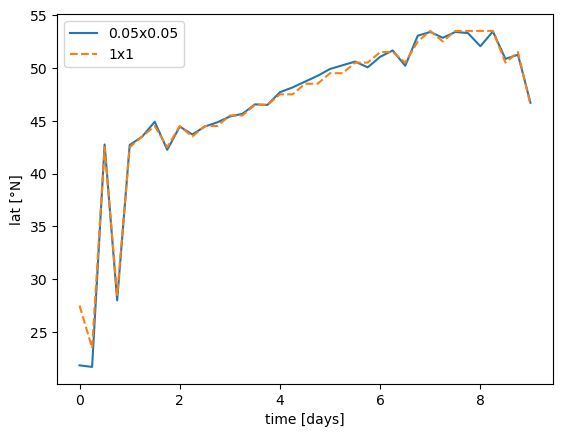

In [24]:
var = 'lat'

plt.plot(df_track['time'],df_track[var],label='0.05x0.05')
plt.plot(df_track_orig['time'],df_track_orig[var],ls='--',label='1x1')
plt.xlabel('time [days]')
plt.ylabel('lat [°N]')
plt.legend()
plt.savefig('/home/b/b380782/CyclEx_figs/'+var+'.png')

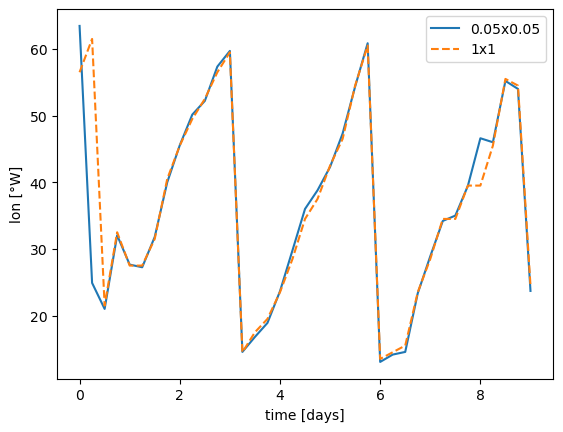

In [25]:
var ='lon'

plt.plot(df_track['time'],df_track[var],label='0.05x0.05')
plt.plot(df_track_orig['time'],df_track_orig[var],ls='--',label='1x1')
plt.xlabel('time [days]')
plt.ylabel('lon [°W]')
plt.legend()

plt.savefig('/home/b/b380782/CyclEx_figs/'+var+'.png')

In [26]:
keys = list(df_track.keys()[6:])

In [27]:
keys

['dpsfc_dt', 'dfi_dt', 'EP', 'ITT', 'Eq1res', 'TADV', 'VMT', 'DIABres']

In [28]:
keys_orig = list(df_track_orig.keys()[6:-5])

In [29]:
keys_orig.append(df_track_orig.keys()[-3])

In [30]:
keys_orig

['dp', 'dfi', 'ep', 'itt', 'eq1res', 'tadv', 'vmt', 'diabres']

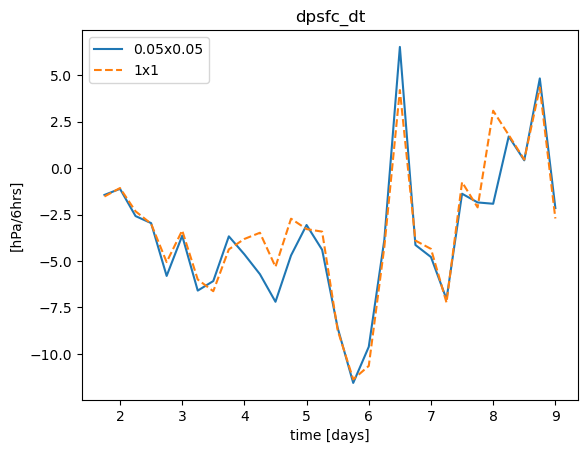

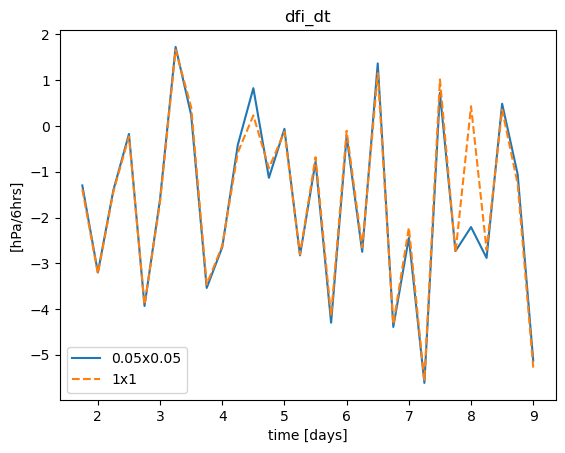

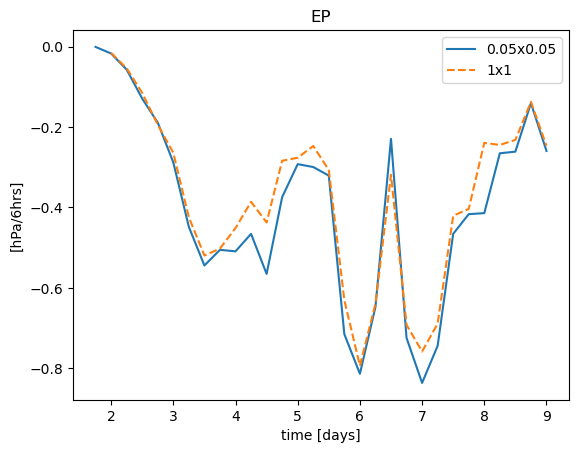

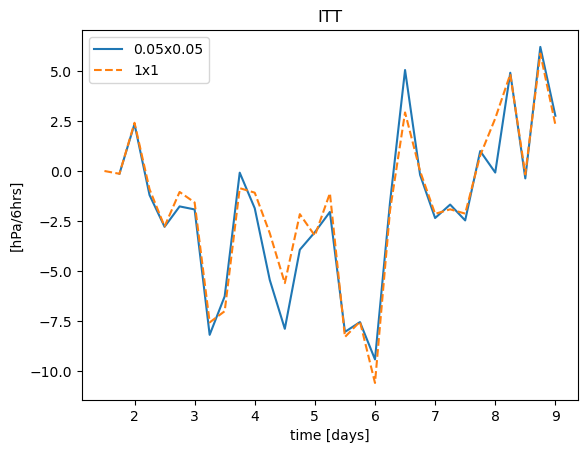

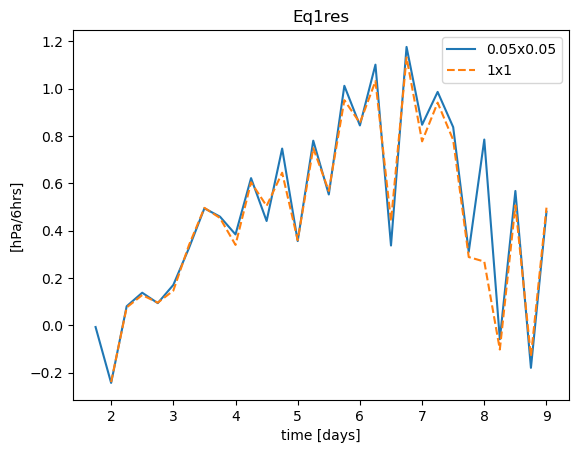

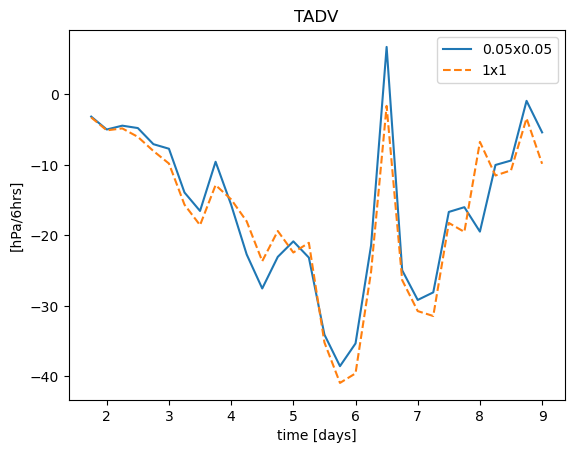

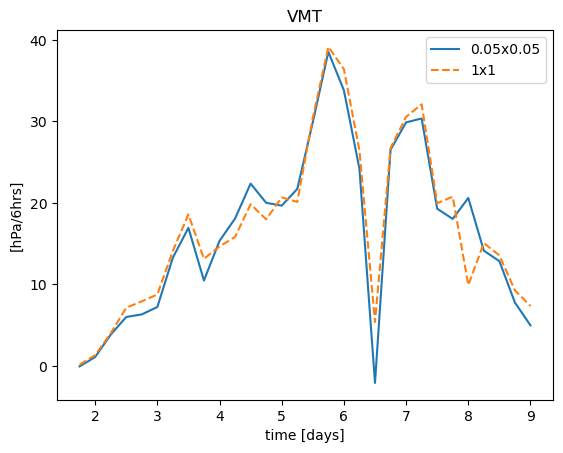

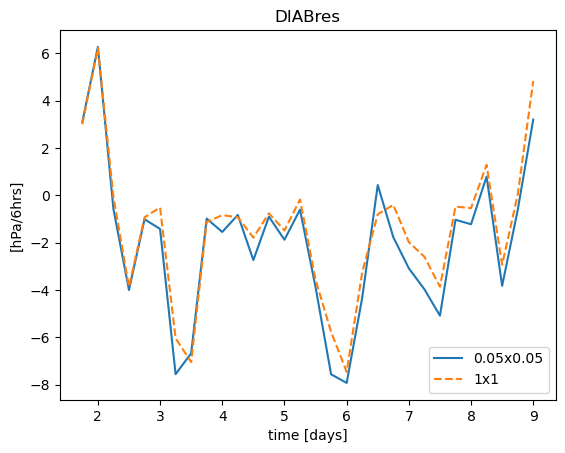

In [31]:
for key,key_orig in zip(keys,keys_orig):
    plt.plot(df_track['time'],df_track[key],label='0.05x0.05')
    plt.plot(df_track_orig['time'],df_track_orig[key_orig],ls='--',label='1x1')
    plt.title(key)
    plt.xlabel('time [days]')
    plt.ylabel('[hPa/6hrs]')
    plt.legend()
    plt.savefig('/home/b/b380782/CyclEx_figs/'+key+'.png')
    plt.show()

Storing data

In [36]:
# remove mslp
df_store = df_track.drop('mslp',axis=1)

In [47]:
# set labels
for key,key_orig in zip(keys,keys_orig):
    df_store = df_store.rename(columns={key:key_orig})

In [48]:
df_store

Unnamed: 0  time         pmin    lon    lat         dp       dfi   
0            0  0.00  1000.992554  63.45  21.85        NaN       NaN  \
1            1  0.25   997.893372  24.90  21.70        NaN       NaN   
2            2  0.50   998.454346  21.00  42.75        NaN       NaN   
3            3  0.75   997.009277  32.05  28.00        NaN       NaN   
4            4  1.00   999.555908  27.65  42.70        NaN       NaN   
5            5  1.25   997.663269  27.25  43.50        NaN       NaN   
6            6  1.50   998.044556  31.80  44.90        NaN       NaN   
7            7  1.75   997.646118  40.00  42.25  -1.439854 -1.298455   
8            8  2.00   996.952942  45.55  44.45  -1.111958 -3.201873   
9            9  2.25   995.527344  50.15  43.70  -2.578686 -1.398549   
10          10  2.50   992.900330  52.20  44.45  -2.956397 -0.172485   
11          11  2.75   988.245789  57.35  44.85  -5.800087 -3.933174   
12          12  3.00   985.206177  59.70  45.40  -3.635371 -1.594907   
13          13  3.25   980.555298  14.55  45.65  -6.590565  1.728497   
14          14  3.50   974.838745  16.80  46.55  -6.076429  0.243146   
15          15  3.75   969.989685  18.90  46.50  -3.669097 -3.539189   
16          16  4.00   967.316772  23.65  47.70  -4.638983 -2.647679   
17          17  4.25   966.005371  29.80  48.15   -5.70832  -0.41179   
18          18  4.50   962.631165  36.00  48.70  -7.191995  0.826998   
19          19  4.75   960.460876  38.80  49.25  -4.696962 -1.132389   
20          20  5.00   959.456299  42.30  49.90  -3.059304 -0.061974   
21          21  5.25   958.772339  47.30  50.25  -4.394081 -2.826512   
22          22  5.50   953.865234  54.35  50.60  -8.597279 -0.780871   
23          23  5.75   949.932861  60.85  50.05 -11.560167 -4.298826   
24          24  6.00   942.506226  13.05  51.05  -9.615369 -0.220053   
25          25  6.25   938.006470  14.15  51.65  -3.863569 -2.749285   
26          26  6.50   941.526733  14.55  50.20   6.527158  1.368573   
27          27  6.75   943.383057  23.35  53.05  -4.134673 -4.391496   
28          28  7.00   944.365479  28.90  53.40  -4.783029  -2.44151   
29          29  7.25   944.550171  34.20  52.85  -7.052899 -5.614992   
30          30  7.50   944.470642  35.00  53.40   -1.37561  0.724622   
31          31  7.75   944.843750  39.45  53.30  -1.844292 -2.734636   
32          32  8.00   947.720947  46.60  52.05  -1.915869 -2.208984   
33          33  8.25   951.256653  46.00  53.45   1.707187 -2.883271   
34          34  8.50   954.463806  55.20  50.85   0.423549  0.486786   
35          35  8.75   960.283997  54.00  51.25   4.830325 -1.055995   
36          36  9.00   962.847351  23.70  46.70  -2.145798 -5.129966   

          ep       itt    eq1res       tadv        vmt   diabres  
0        NaN       NaN       NaN        NaN        NaN       NaN  
1        NaN       NaN       NaN        NaN        NaN       NaN  
2        NaN       NaN       NaN        NaN        NaN       NaN  
3        NaN       NaN       NaN        NaN        NaN       NaN  
4        NaN       NaN       NaN        NaN        NaN       NaN  
5        NaN       NaN       NaN        NaN        NaN       NaN  
6        NaN       NaN       NaN        NaN        NaN       NaN  
7  -0.001039 -0.132859 -0.007501  -3.161065  -0.070707  3.098913  
8  -0.017426  2.351068 -0.243726  -4.989049   1.071043  6.269072  
9  -0.057437 -1.202944  0.080246  -4.445321   3.817695 -0.575318  
10 -0.129516 -2.791819  0.137424  -4.784492   5.993924 -4.001249  
11 -0.189275 -1.771041  0.093405  -7.069056   6.309308 -1.011294  
12 -0.288197 -1.922625  0.170357  -7.716262   7.215748 -1.422113  
13 -0.448578 -8.195584    0.3251 -13.919763  13.281652 -7.557469  
14 -0.544442 -6.269291  0.494159 -16.537777  16.941552 -6.673063  
15 -0.505526 -0.083318  0.458938  -9.565486  10.467845 -0.985677  
16  -0.50931 -1.865762  0.383768 -15.656307  15.339648 -1.549105  
17 -0.465855  -5.45233  0.621658  -22.70552  18.081868 -0.828

In [50]:
#####################################################
# Write out track data
#####################################################
# File to save cyclone-associated PTE output 
dataout='/work/bb1152/Module_A/A6_CyclEx/pp_data/'

df_track.to_csv(dataout+"/cyclone_PTE_timeseries/PTE_for_"+exp+"_"+data_dt+"_"+data_res+"_upper"+str(int(p2level))+"hPa_box"+str(int(boxsize))+".csv", header=True)


#### 